In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
import healpy as hp
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from readData import *
from nearNeighbors import *
from localBKG import *
from scipy import stats
from bestBkg import *
from astropy import stats
# from findRadius import *

In [2]:
# Reads in data files for use in readData.py

hdulist = fits.open('/Users/mtownsend/anaconda/Data/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
hdulist2 = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdulist3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010.fits') # this is one sweep file of the DECaLS data

# hdulist = fits.open('/Users/mindy/Research/Data/lrgProjectData/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
# hdulist2 = fits.open('/Users/mindy/Research/Data/lrgProjectData/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
# hdulist3 = fits.open('/Users/mindy/Research/Data/lrgProjectData/sweep-240p005-250p010.fits') # this is one sweep file of the DECaLS data


SpecObj_data = hdulist[1].data
SDSS_data = hdulist2[1].data
DECaLS_data = hdulist3[1].data

In [3]:
ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, gmag_BKG, zmag_BKG, color_BKG, rmag_LRG, gmag_LRG, zmag_LRG, color_LRG, z_LRG = readData(SpecObj_data, SDSS_data, DECaLS_data)

print("end readdata")

length of sdss lrg array:  4851200
length of lrg only array: 1406221
length of row matched targets in SDSS and DECaLS:  4851200
length of DECaLS targets in brick:  4529240
length of id_ALL:  4529240
<class 'numpy.ndarray'>
length of id_MATCHED with LRG_cut (id_LRG): 1528
length of idcut: 4529240
length of idcut = 1 (is an LRG in DECaLS-only file): 1151
length of idcut = 0 (is not an LRG in DECaLS-only file): 4528089
length of z_lrg: 1151
end readdata


In [4]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

end cosmoCalc


In [5]:
row = 10
column = 10
# creates histogram for survey sources; excludes LRGs
H, xedges, yedges = np.histogram2d(rmag_BKG, color_BKG, normed=False)

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(17.5) # * (3600.**2.)) # converts square degrees to square arcseconds

print(np.sum(sd))

distance = 0.4

distance_kpc, near = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

print('end nearNeighbor')

23601.885714285716
end nearNeighbor


In [6]:
# distance_r2 = 5.
# distance_r3 = 10.

# numbkg, med_local, sigma, omega, Nbkg, r2, dist_r2, r3, dist_r3, zip_list_LRG, zip_list_BKG = localBKG_and_interlopers(distance_kpc, distance_r2, distance_r3, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

# print("end interlopers")

In [39]:
# kpc_DA_array = np.array(kpc_DA)

ra_cut0 = ra_LRG[np.where((z_LRG > 0.2) & (z_LRG < 0.25))]
dec_cut0 = dec_LRG[np.where((z_LRG > 0.2) & (z_LRG < 0.25))]

ra_cut1 = ra_LRG[np.where((z_LRG > 0.25) & (z_LRG < 0.3))]
dec_cut1 = dec_LRG[np.where((z_LRG > 0.25) & (z_LRG < 0.3))]

ra_cut2 = ra_LRG[np.where((z_LRG > 0.3) & (z_LRG < 0.35))]
dec_cut2 = dec_LRG[np.where((z_LRG > 0.3) & (z_LRG < 0.35))]

ra_cut3 = ra_LRG[np.where((z_LRG > 0.35) & (z_LRG < 0.4))]
dec_cut3 = dec_LRG[np.where((z_LRG > 0.35) & (z_LRG < 0.4))]

ra_cut4 = ra_LRG[np.where((z_LRG > 0.4) & (z_LRG < 0.45))]
dec_cut4 = dec_LRG[np.where((z_LRG > 0.4) & (z_LRG < 0.45))]

ra_cut5 = ra_LRG[np.where((z_LRG > 0.45) & (z_LRG < 0.5))]
dec_cut5 = dec_LRG[np.where((z_LRG > 0.45) & (z_LRG < 0.5))]

ra_cut6 = ra_LRG[np.where((z_LRG > 0.5) & (z_LRG < 0.55))]
dec_cut6 = dec_LRG[np.where((z_LRG > 0.5) & (z_LRG < 0.55))]

ra_cut7 = ra_LRG[np.where((z_LRG > 0.55) & (z_LRG < 0.6))]
dec_cut7 = dec_LRG[np.where((z_LRG > 0.55) & (z_LRG < 0.6))]

ra_cut8 = ra_LRG[np.where((z_LRG > 0.6) & (z_LRG < 0.65))]
dec_cut8 = dec_LRG[np.where((z_LRG > 0.6) & (z_LRG < 0.65))]

ra_cut9 = ra_LRG[np.where((z_LRG > 0.65) & (z_LRG < 0.7))]
dec_cut9 = dec_LRG[np.where((z_LRG > 0.65) & (z_LRG < 0.7))]


radius_max = 0.6

zip_list_LRG0 = list(zip(ra_cut0, dec_cut0))
zip_list_LRG1 = list(zip(ra_cut1, dec_cut1))
zip_list_LRG2 = list(zip(ra_cut2, dec_cut2))
zip_list_LRG3 = list(zip(ra_cut3, dec_cut3))
zip_list_LRG4 = list(zip(ra_cut4, dec_cut4))
zip_list_LRG5 = list(zip(ra_cut5, dec_cut5))
zip_list_LRG6 = list(zip(ra_cut6, dec_cut6))
zip_list_LRG7 = list(zip(ra_cut7, dec_cut7))
zip_list_LRG8 = list(zip(ra_cut8, dec_cut8))
zip_list_LRG9 = list(zip(ra_cut9, dec_cut9))

zip_list_BKG = list(zip(ra_BKG, dec_BKG))

gal_tree_outer = KDTree(zip_list_BKG)

ind_outer0 = gal_tree_outer.query_radius(zip_list_LRG0, r=radius_max)
ind_outer1 = gal_tree_outer.query_radius(zip_list_LRG1, r=radius_max)
ind_outer2 = gal_tree_outer.query_radius(zip_list_LRG2, r=radius_max)
ind_outer3 = gal_tree_outer.query_radius(zip_list_LRG3, r=radius_max)
ind_outer4 = gal_tree_outer.query_radius(zip_list_LRG4, r=radius_max)
ind_outer5 = gal_tree_outer.query_radius(zip_list_LRG5, r=radius_max)
ind_outer6 = gal_tree_outer.query_radius(zip_list_LRG6, r=radius_max)
ind_outer7 = gal_tree_outer.query_radius(zip_list_LRG7, r=radius_max)
ind_outer8 = gal_tree_outer.query_radius(zip_list_LRG8, r=radius_max)
ind_outer9 = gal_tree_outer.query_radius(zip_list_LRG9, r=radius_max)

nn_outer0, dist_outer0 = gal_tree_outer.query_radius(zip_list_LRG0, r=radius_max, return_distance=True)
nn_outer1, dist_outer1 = gal_tree_outer.query_radius(zip_list_LRG1, r=radius_max, return_distance=True)
nn_outer2, dist_outer2 = gal_tree_outer.query_radius(zip_list_LRG2, r=radius_max, return_distance=True)
nn_outer3, dist_outer3 = gal_tree_outer.query_radius(zip_list_LRG3, r=radius_max, return_distance=True)
nn_outer4, dist_outer4 = gal_tree_outer.query_radius(zip_list_LRG4, r=radius_max, return_distance=True)
nn_outer5, dist_outer5 = gal_tree_outer.query_radius(zip_list_LRG5, r=radius_max, return_distance=True)
nn_outer6, dist_outer6 = gal_tree_outer.query_radius(zip_list_LRG6, r=radius_max, return_distance=True)
nn_outer7, dist_outer7 = gal_tree_outer.query_radius(zip_list_LRG7, r=radius_max, return_distance=True)
nn_outer8, dist_outer8 = gal_tree_outer.query_radius(zip_list_LRG8, r=radius_max, return_distance=True)
nn_outer9, dist_outer9 = gal_tree_outer.query_radius(zip_list_LRG9, r=radius_max, return_distance=True)

In [6]:
radius_max = 0.6

ra_cut = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
dec_cut = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_LRG = list(zip(ra_cut, dec_cut))
zip_list_BKG = list(zip(ra_BKG, dec_BKG))

# Creates a tree of EDR sources
gal_tree_outer = KDTree(zip_list_BKG)

# find indices of sources
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max)

# returns a list of sources and their distances from the LRG within radius dist_outer
nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max, return_distance=True)

In [7]:
# radius_max = 0.4

# ra_cut = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
# dec_cut = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

# # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
# zip_list_LRG = list(zip(ra_cut, dec_cut))
# zip_list_BKG = list(zip(ra_BKG, dec_BKG))

# # Creates a tree of EDR sources
# gal_tree_outer = KDTree(zip_list_BKG)

# # find indices of sources
# # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# # arrays could be empty
# ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max)

# # returns a list of sources and their distances from the LRG within radius dist_outer
# nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max, return_distance=True)


# b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19., 20.,21.,22.,23.,24.,25.,26.,27.,28.,29.]
# b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.] #,10.,11.,12.]
b = np.linspace(0,49.,50)

sumSigma0 = []
sumSigma1 = []
sumSigma2 = []
sumSigma3 = []
sumSigma4 = []
sumSigma5 = []
sumSigma6 = []
sumSigma7 = []
sumSigma8 = []
sumSigma9 = []
sumSigma10 = []
sumSigma11 = []
sumSigma12 = []
sumSigma13 = []
sumSigma14 = []
sumSigma15 = []
sumSigma16 = []
sumSigma17 = []
sumSigma18 = []
sumSigma19 = []
sumSigma20 = []
sumSigma21 = []
sumSigma22 = []
sumSigma23 = []
sumSigma24 = []
sumSigma25 = []
sumSigma26 = []
sumSigma27 = []
sumSigma28 = []
sumSigma29 = []
sumSigma30 = []
sumSigma31 = []
sumSigma32 = []
sumSigma33 = []
sumSigma34 = []
sumSigma35 = []
sumSigma36 = []
sumSigma37 = []
sumSigma38 = []
sumSigma39 = []
sumSigma40 = []
sumSigma41 = []
sumSigma42 = []
sumSigma43 = []
sumSigma44 = []
sumSigma45 = []
sumSigma46 = []
sumSigma47 = []
sumSigma48 = []
sumSigma49 = []

outer_radius0 = []
outer_radius1 = []
outer_radius2 = []
outer_radius3 = []
outer_radius4 = []
outer_radius5 = []
outer_radius6 = []
outer_radius7 = []
outer_radius8 = []
outer_radius9 = []
outer_radius10 = []
outer_radius11 = []
outer_radius12 = []
outer_radius13 = []
outer_radius14 = []
outer_radius15 = []
outer_radius16 = []
outer_radius17 = []
outer_radius18 = []
outer_radius19 = []
outer_radius20 = []
outer_radius21 = []
outer_radius22 = []
outer_radius23 = []
outer_radius24 = []
outer_radius25 = []
outer_radius26 = []
outer_radius27 = []
outer_radius28 = []
outer_radius29 = []
outer_radius30 = []
outer_radius31 = []
outer_radius32 = []
outer_radius33 = []
outer_radius34 = []
outer_radius35 = []
outer_radius36 = []
outer_radius37 = []
outer_radius38 = []
outer_radius39 = []
outer_radius40 = []
outer_radius41 = []
outer_radius42 = []
outer_radius43 = []
outer_radius44 = []
outer_radius45 = []
outer_radius46 = []
outer_radius47 = []
outer_radius48 = []
outer_radius49 = []

inner_radius0 = []
inner_radius1 = []
inner_radius2 = []
inner_radius3 = []
inner_radius4 = []
inner_radius5 = []
inner_radius6 = []
inner_radius7 = []
inner_radius8 = []
inner_radius9 = []
inner_radius10 = []
inner_radius11 = []
inner_radius12 = []
inner_radius13 = []
inner_radius14 = []
inner_radius15 = []
inner_radius16 = []
inner_radius17 = []
inner_radius18 = []
inner_radius19 = []
inner_radius20 = []
inner_radius21 = []
inner_radius22 = []
inner_radius23 = []
inner_radius24 = []
inner_radius25 = []
inner_radius26 = []
inner_radius27 = []
inner_radius28 = []
inner_radius29 = []
inner_radius30 = []
inner_radius31 = []
inner_radius32 = []
inner_radius33 = []
inner_radius34 = []
inner_radius35 = []
inner_radius36 = []
inner_radius37 = []
inner_radius38 = []
inner_radius39 = []
inner_radius40 = []
inner_radius41 = []
inner_radius42 = []
inner_radius43 = []
inner_radius44 = []
inner_radius45 = []
inner_radius46 = []
inner_radius47 = []
inner_radius48 = []
inner_radius49 = []

sumbkg0 = []
sumbkg1 = []
sumbkg2 = []
sumbkg3 = []
sumbkg4 = []
sumbkg5 = []
sumbkg6 = []
sumbkg7 = []
sumbkg8 = []
sumbkg9 = []
sumbkg10 = []
sumbkg11 = []
sumbkg12 = []
sumbkg13 = []
sumbkg14 = []
sumbkg15 = []
sumbkg16 = []
sumbkg17 = []
sumbkg18 = []
sumbkg19 = []
sumbkg20 = []
sumbkg21 = []
sumbkg22 = []
sumbkg23 = []
sumbkg24 = []
sumbkg25 = []
sumbkg26 = []
sumbkg27 = []
sumbkg28 = []
sumbkg29 = []
sumbkg30 = []
sumbkg31 = []
sumbkg32 = []
sumbkg33 = []
sumbkg34 = []
sumbkg35 = []
sumbkg36 = []
sumbkg37 = []
sumbkg38 = []
sumbkg39 = []
sumbkg40 = []
sumbkg41 = []
sumbkg42 = []
sumbkg43 = []
sumbkg44 = []
sumbkg45 = []
sumbkg46 = []
sumbkg47 = []
sumbkg48 = []
sumbkg49 = []

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
error7 = []
error8 = []
error9 = []
error10 = []
error11 = []
error12 = []
error13 = []
error14 = []
error15 = []
error16 = []
error17 = []
error18 = []
error19 = []
error20 = []
error21 = []
error22 = []
error23 = []
error24 = []
error25 = []
error26 = []
error27 = []
error28 = []
error29 = []
error30 = []
error31 = []
error32 = []
error33 = []
error34 = []
error35 = []
error36 = []
error37 = []
error38 = []
error39 = []
error40 = []
error41 = []
error42 = []
error43 = []
error44 = []
error45 = []
error46 = []
error47 = []
error48 = []
error49 = []

sigma0 = []
sigma1 = []
sigma2 = []
sigma3 = []
sigma4 = []
sigma5 = []
sigma6 = []
sigma7 = []
sigma8 = []
sigma9 = []
sigma10 = []
sigma11 = []
sigma12 = []
sigma13 = []
sigma14 = []
sigma15 = []
sigma16 = []
sigma17 = []
sigma18 = []
sigma19 = []
sigma20 = []
sigma21 = []
sigma22 = []
sigma23 = []
sigma24 = []
sigma25 = []
sigma26 = []
sigma27 = []
sigma28 = []
sigma29 = []
sigma30 = []
sigma31 = []
sigma32 = []
sigma33 = []
sigma34 = []
sigma35 = []
sigma36 = []
sigma37 = []
sigma38 = []
sigma39 = []
sigma40 = []
sigma41 = []
sigma42 = []
sigma43 = []
sigma44 = []
sigma45 = []
sigma46 = []
sigma47 = []
sigma48 = []
sigma49 = []

area0 = []
area1 = []
area2 = []
area3 = []
area4 = []
area5 = []
area6 = []
area7 = []
area8 = []
area9 = []
area10 = []
area11 = []
area12 = []
area13 = []
area14 = []
area15 = []
area16 = []
area17 = []
area18 = []
area19 = []
area20 = []
area21 = []
area22 = []
area23 = []
area24 = []
area25 = []
area26 = []
area27 = []
area28 = []
area29 = []
area30 = []
area31 = []
area32 = []
area33 = []
area34 = []
area35 = []
area36 = []
area37 = []
area38 = []
area39 = []
area40 = []
area41 = []
area42 = []
area43 = []
area44 = []
area45 = []
area46 = []
area47 = []
area48 = []
area49 = []

sumSigma = [sumSigma0, sumSigma1, sumSigma2, sumSigma3, sumSigma4, sumSigma5, sumSigma6, sumSigma7, sumSigma8, sumSigma9, sumSigma10, sumSigma11, sumSigma12, sumSigma13, sumSigma14, sumSigma15, sumSigma16, sumSigma17, sumSigma18, sumSigma19, sumSigma20, sumSigma21, sumSigma22, sumSigma23, sumSigma24, sumSigma25, sumSigma26, sumSigma27, sumSigma28, sumSigma29, sumSigma30, sumSigma31, sumSigma32, sumSigma33, sumSigma34, sumSigma35, sumSigma36, sumSigma37, sumSigma38, sumSigma39, sumSigma40, sumSigma41, sumSigma42, sumSigma43, sumSigma44, sumSigma45, sumSigma46, sumSigma47, sumSigma48, sumSigma49] 
outer_radius = [outer_radius0, outer_radius1, outer_radius2, outer_radius3, outer_radius4, outer_radius5, outer_radius6, outer_radius7, outer_radius8, outer_radius9, outer_radius10, outer_radius11, outer_radius12, outer_radius13, outer_radius14, outer_radius15, outer_radius16, outer_radius17, outer_radius18, outer_radius19, outer_radius20, outer_radius21, outer_radius22, outer_radius23, outer_radius24, outer_radius25, outer_radius26, outer_radius27, outer_radius28, outer_radius29, outer_radius30, outer_radius31, outer_radius32, outer_radius33, outer_radius34, outer_radius35, outer_radius36, outer_radius37, outer_radius38, outer_radius39, outer_radius40, outer_radius41, outer_radius42, outer_radius43, outer_radius44, outer_radius45, outer_radius46, outer_radius47, outer_radius48, outer_radius49]
inner_radius = [inner_radius0, inner_radius1, inner_radius2, inner_radius3, inner_radius4, inner_radius5, inner_radius6, inner_radius7, inner_radius8, inner_radius9, inner_radius10, inner_radius11, inner_radius12, inner_radius13, inner_radius14, inner_radius15, inner_radius16, inner_radius17, inner_radius18, inner_radius19, inner_radius20, inner_radius21, inner_radius22, inner_radius23, inner_radius24, inner_radius25, inner_radius26, inner_radius27, inner_radius28, inner_radius29, inner_radius30, inner_radius31, inner_radius32, inner_radius33, inner_radius34, inner_radius35, inner_radius36, inner_radius37, inner_radius38, inner_radius39, inner_radius40, inner_radius41, inner_radius42, inner_radius43, inner_radius44, inner_radius45, inner_radius46, inner_radius47, inner_radius48, inner_radius49]
sumbkg = [sumbkg0, sumbkg1, sumbkg2, sumbkg3, sumbkg4, sumbkg5, sumbkg6, sumbkg7, sumbkg8, sumbkg9, sumbkg10, sumbkg11, sumbkg12, sumbkg13, sumbkg14, sumbkg15, sumbkg16, sumbkg17, sumbkg18, sumbkg19, sumbkg20, sumbkg21, sumbkg22, sumbkg23, sumbkg24, sumbkg25, sumbkg26, sumbkg27, sumbkg28, sumbkg29, sumbkg30, sumbkg31, sumbkg32, sumbkg33, sumbkg34, sumbkg35, sumbkg36, sumbkg37, sumbkg38, sumbkg39, sumbkg40, sumbkg41, sumbkg42, sumbkg43, sumbkg44, sumbkg45, sumbkg46, sumbkg47, sumbkg48, sumbkg49]
error = [error0, error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12, error13, error14, error15, error16, error17, error18, error19, error20, error21, error22, error23, error24, error25, error26, error27, error28, error29, error30, error31, error32, error33, error34, error35, error36, error37, error38, error39, error40, error41, error42, error43, error44, error45, error46, error47, error48, error49]
sigma = [sigma0, sigma1, sigma2, sigma3, sigma4, sigma5, sigma6, sigma7, sigma8, sigma9, sigma10, sigma11, sigma12, sigma13, sigma14, sigma15, sigma16, sigma17, sigma18, sigma19, sigma20, sigma21, sigma22, sigma23, sigma24, sigma25, sigma26, sigma27, sigma28, sigma29, sigma30, sigma31, sigma32, sigma33, sigma34, sigma35, sigma36, sigma37, sigma38, sigma39, sigma40, sigma41, sigma42, sigma43, sigma44, sigma45, sigma46, sigma47, sigma48, sigma49]
area = [area0, area1, area2, area3, area4, area5, area6, area7, area8, area9, area10, area11, area12, area13, area14, area15, area16, area17, area18, area19, area20, area21, area22, area23, area24, area25, area26, area27, area28, area29, area30, area31, area32, area33, area34, area35, area36, area37, area38, area39, area40, area41, area42, area43, area44, area45, area46, area47, area48, area49]

sumSigma_dict = dict(enumerate(sumSigma))
outerradius_dict = dict(enumerate(outer_radius))
innerradius_dict = dict(enumerate(inner_radius))
sumbkg_dict = dict(enumerate(sumbkg))
error_dict = dict(enumerate(error))
sigma_dict = dict(enumerate(sigma))
area_dict = dict(enumerate(area))

for i in range(len(ind_outer)):
    for j in range(len(b)):
        result = bestBKG(50., b[j], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
        sumSigma_dict[j].append(result[0])
        outerradius_dict[j].append(result[1]) 
        innerradius_dict[j].append(result[2])
        sumbkg_dict[j].append(result[3])
        error_dict[j].append(result[4]) 
        sigma_dict[j].append(result[5]) 
        area_dict[j].append(result[6]) 
        
print('end bestBKG')

end bestBKG


In [ ]:
# print(len(error_dict[0][300]))
# print(len(sigma_dict[0]))
# print(len(sumbkg_dict[0]))
# print(len(area_dict[0]))

# error = []
# for i in range(len(b)):
#     error.append(np.sqrt(sumbkg_dict[i]) / area_dict[i])
# print(len(error))
# print(len(error[1]))
# # print(error[19])

# print(sumSigma_dict[0][0])
c = np.array([sumSigma_dict[0][0], sumSigma_dict[1][0], sumSigma_dict[2][0], sumSigma_dict[3][0], sumSigma_dict[4][0], sumSigma_dict[5][0], sumSigma_dict[6][0]])
d = np.array([sumSigma_dict[0][1], sumSigma_dict[1][1], sumSigma_dict[2][1], sumSigma_dict[3][1], sumSigma_dict[4][1], sumSigma_dict[5][1], sumSigma_dict[6][1]])
# a = np.array([sumSigma_dict[0:3][0]])
# print(c)
# print('--------')
# print(d)
# print('--------')
stdevc = np.std(c)
print(stdevc)
print('--------')
stdevd = np.std(d)
print(stdevd)
print('--------')

stdev = []
z = []
for i in range(len(ra_cut)):
    for j in range(len(b)-6):
        a = np.array([sumSigma_dict[j][i], sumSigma_dict[j+1][i], sumSigma_dict[j+2][i], sumSigma_dict[j+3][i], sumSigma_dict[j+4][i], sumSigma_dict[j+5][i], sumSigma_dict[j+6][i]])
        z.append(np.std(a))
#         print(len(z))        
    stdev.append([z])
    z = []
    
# print('--------')
print(stdev[0])
print('--------')
print(stdev[1])
print('--------')
# print(stdev)
# print(len(stdev[0]))

# sumSig_temp = []
outer_temp = []
error_temp = []
for i in range(len(ra_cut)):
    for j in range(len(b)):
        outer_temp.append(outerradius_dict[j][i])
        error_temp.append(error[j][i])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
        plt.plot(outer_temp, error_temp) #, marker='o')
#         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
    outer_temp = []
    error_temp = []

plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Poisson Error vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Poisson$ $Error$', fontsize=15)    
    
plt.show()
    

1980.3153992330942
--------
8899.94880063934
--------
[[1980.3153992330942, 1894.9053233117017, 1789.1371606913074, 2233.2591564350732, 2077.558629871658, 2203.9372051238156, 2019.3120700506838, 2039.2769796665675, 1750.4599545124609, 1727.8924108656774, 1672.8358196196045, 1953.222306420053, 2149.7846914412735, 2179.766908548904, 2169.824418516776, 2025.2408949524402, 971.8329697501784, 1116.5632751594458, 1175.2501172329414, 817.8611734842182, 975.9561665716362, 1412.5586875343079, 2341.5506584061864, 2379.526875514973, 2192.1310280977536, 1568.863329207969, 1237.2686046104923, 901.1614679182051, 838.1716029359989, 565.1456967451761, 654.860381081475, 724.6209392162086, 725.8858984439009, 687.5936698293889, 670.4729965768191, 869.0805806120801, 1031.4804607938408, 1215.6709545860333, 1427.1325548389634, 1398.9009147184438, 1001.6834811926038, 527.9345888209363, 566.9094023363501, 581.1093910166517]]
--------
[[8899.94880063934, 9441.81477735329, 6395.094173905113, 4410.354824923461, 

306
306
306


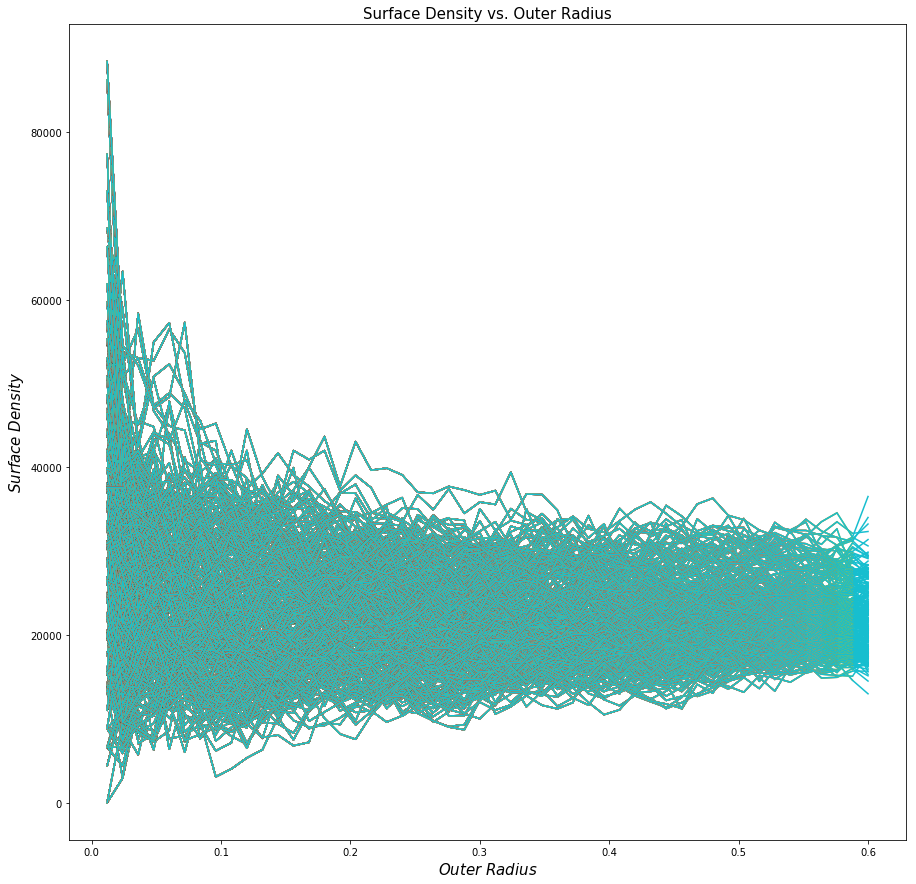

In [76]:
# print(sumSigma_dict[9][0])
# print(sumSigma_dict[9])
print(len(error_dict[1]))
print(len(sumSigma_dict[1]))
print(len(outerradius_dict[1]))

# plt.xkcd()

sumSig_temp = []
outer_temp = []
# error_temp = []

for i in range(len(ra_cut)):
    for j in range(len(b)):
        sumSig_temp.append(sumSigma_dict[j][i])
        outer_temp.append(outerradius_dict[j][i])
#         error_temp.append(error[j][i])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
        plt.plot(outer_temp, sumSig_temp) #, marker='o')
#         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
    sumSig_temp = []
    outer_temp = []
#     error_temp = []
    
plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Surface Density vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Surface$ $Density$', fontsize=15)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/sd_v_radius50.pdf")

plt.show()
        

306
306


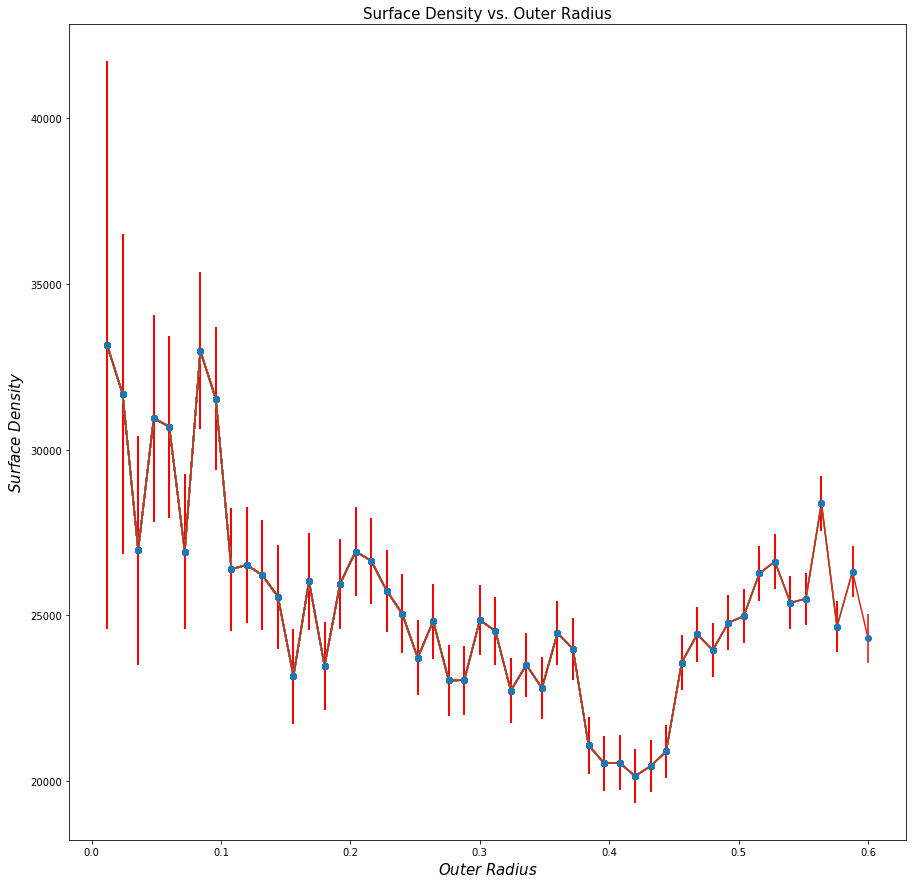

In [81]:
print(len(sumSigma_dict[1]))
print(len(outerradius_dict[1]))

sumSig_temp = []
outer_temp = []
error_temp = []
for j in range(len(b)):
    sumSig_temp.append(sumSigma_dict[j][3])
    outer_temp.append(outerradius_dict[j][3])
    error_temp.append(error[j][3])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
    plt.plot(outer_temp, sumSig_temp) #, marker='o')
    plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')

plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Surface Density vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Surface$ $Density$', fontsize=15)    
    
plt.show()

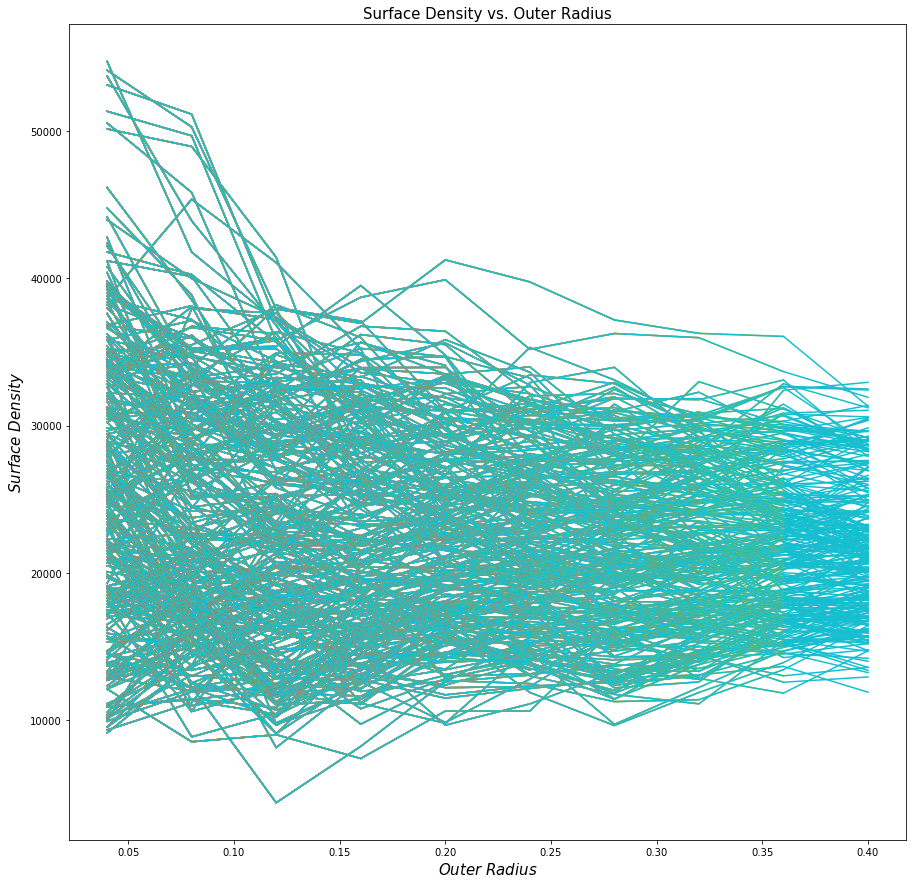

In [22]:
sumSig_temp = []
outer_temp = []
# error_temp = []

for i in range(len(ra_cut)):
    for j in range(len(b)):
        sumSig_temp.append(sumSigma_dict[j][i])
        outer_temp.append(outerradius_dict[j][i])
        error_temp.append(error_dict[j][i])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
        plt.plot(outer_temp, sumSig_temp) #, marker='o')
#         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
    sumSig_temp = []
    outer_temp = []
#     error_temp = []
    
plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Surface Density vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Surface$ $Density$', fontsize=15)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/sd_v_radius.pdf")
plt.show()

In [8]:
# radius_max = 0.4

# ra_cut = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
# dec_cut = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

# # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
# zip_list_LRG = list(zip(ra_cut, dec_cut))
# zip_list_BKG = list(zip(ra_BKG, dec_BKG))

# # Creates a tree of EDR sources
# gal_tree_outer = KDTree(zip_list_BKG)

# # find indices of sources
# # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# # arrays could be empty
# ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max)

# # returns a list of sources and their distances from the LRG within radius dist_outer
# nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max, return_distance=True)


# b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19.]


# sumSigma = []
# outer_radius = []
# inner_radius = []
# sumbkg = []
# error = []
# sigma = []
# area = []

# for i in range(len(ra_cut)):
#     result0 = bestBKG(20., b[0], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result1 = bestBKG(20., b[1], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result2 = bestBKG(20., b[2], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result3 = bestBKG(20., b[3], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result4 = bestBKG(20., b[4], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result5 = bestBKG(20., b[5], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result6 = bestBKG(20., b[6], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result7 = bestBKG(20., b[7], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result8 = bestBKG(20., b[8], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result9 = bestBKG(20., b[9], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result10 = bestBKG(20., b[10], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result11 = bestBKG(20., b[11], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result12 = bestBKG(20., b[12], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result13 = bestBKG(20., b[13], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result14 = bestBKG(20., b[14], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result15 = bestBKG(20., b[15], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result16 = bestBKG(20., b[16], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result17 = bestBKG(20., b[17], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result18 = bestBKG(20., b[18], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     result19 = bestBKG(20., b[19], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
    
#     sumSigma0.append(result[0])
#     outer_radius0.append(result[1])
#     inner_radius0.append(result[2])
#     sumbkg0.append(result[3])
#     error0.append(result[4])
#     sigma0.append(result[5])
#     area0.append(result[6])
    
#     sumSigma1.append(result[0])
#     outer_radius1.append(result[1])
#     inner_radius1.append(result[2])
#     sumbkg1.append(result[3])
#     error1.append(result[4])
#     sigma1.append(result[5])
#     area1.append(result[6])
    
#     sumSigma2.append(result[0])
#     outer_radius2.append(result[1])
#     inner_radius2.append(result[2])
#     sumbkg2.append(result[3])
#     error2.append(result[4])
#     sigma2.append(result[5])
#     area2.append(result[6])
    
#     sumSigma3.append(result[0])
#     outer_radius3.append(result[1])
#     inner_radius3.append(result[2])
#     sumbkg3.append(result[3])
#     error3.append(result[4])
#     sigma3.append(result[5])
#     area3.append(result[6])
    
#     sumSigma4.append(result[0])
#     outer_radius4.append(result[1])
#     inner_radius4.append(result[2])
#     sumbkg4.append(result[3])
#     error4.append(result[4])
#     sigma4.append(result[5])
#     area4.append(result[6])
    
#     sumSigma4.append(result[0])
#     outer_radius4.append(result[1])
#     inner_radius4.append(result[2])
#     sumbkg4.append(result[3])
#     error4.append(result[4])
#     sigma4.append(result[5])
#     area4.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     sumbkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    


In [15]:
print(result[1])

0.05


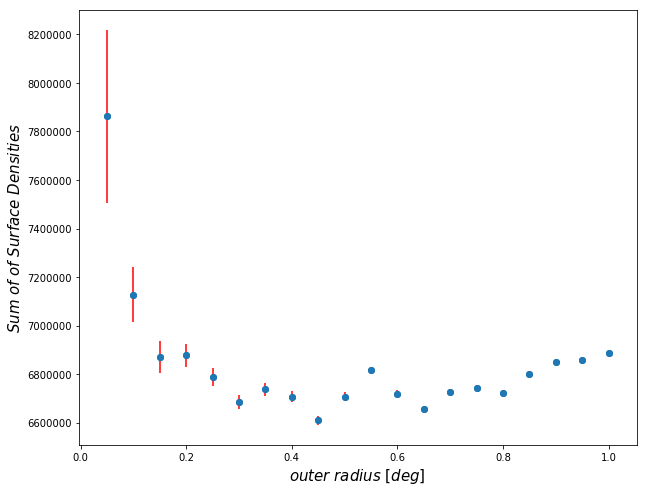

In [54]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius, sumSigma)
plt.errorbar(outer_radius, sumSigma, yerr = error, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

In [16]:
# radius_outer = 1.
# # radius_outer_kpc = 7000.

# # # Converts outer radius from kpc to degree
# # radius_outer_deg = []
# # for i in range(len(kpc_DA)):
# #     radius_outer_deg.append((radius_outer_kpc / kpc_DA[i]) * 1. / 3600.)

# # print(radius_outer_deg)

# # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
# zip_list_LRG = list(zip(ra_cut, dec_cut))
# zip_list_BKG = list(zip(ra_cut, dec_cut))

# # Creates a tree of EDR sources
# gal_tree_outer = KDTree(zip_list_BKG)

# # find indices of sources
# # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# # arrays could be empty
# ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_outer)

# # returns a list of sources and their distances from the LRG within radius dist_outer
# nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_outer, return_distance=True)

# print(ind_outer.shape)
# print(len(ind_outer[1]))
# print(dist_outer.shape)
# # print(len(dist_outer[np.where(z_LRG > 0.25)]))

(48,)
14
(48,)


In [40]:
b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19.]


# sumSigma = []
# outer_radius = []
# inner_radius = []
# bkg = []
# error = []
# sigma = []
# area = []
sumSigma0 = []
outer_radius0 = []
inner_radius0 = []
bkg0 = []
error0 = []
sigma0 = []
area0 = []
sumSigma1 = []
outer_radius1 = []
inner_radius1 = []
bkg1 = []
error1 = []
sigma1 = []
area1 = []
sumSigma2 = []
outer_radius2 = []
inner_radius2 = []
bkg2 = []
error2 = []
sigma2 = []
area2 = []
sumSigma3 = []
outer_radius3 = []
inner_radius3 = []
bkg3 = []
error3 = []
sigma3 = []
area3 = []
sumSigma4 = []
outer_radius4 = []
inner_radius4 = []
bkg4 = []
error4 = []
sigma4 = []
area4 = []
sumSigma5 = []
outer_radius5 = []
inner_radius5 = []
bkg5 = []
error5 = []
sigma5 = []
area5 = []
sumSigma6 = []
outer_radius6 = []
inner_radius6 = []
bkg6 = []
error6 = []
sigma6 = []
area6= []
sumSigma7 = []
outer_radius7 = []
inner_radius7 = []
bkg7 = []
error7 = []
sigma7 = []
area7= []
sumSigma8 = []
outer_radius8 = []
inner_radius8 = []
bkg8 = []
error8 = []
sigma8 = []
area8 = []
sumSigma9 = []
outer_radius9 = []
inner_radius9 = []
bkg9 = []
error9 = []
sigma9 = []
area9 = []

for i in range(len(b)):
#     result = bestBKG(20., b[i], dist_outer, ind_outer, radius_max, kpc_DA_cut, xedges, yedges, rmag_BKG, color_BKG)
    result0 = bestBKG(20., b[i], dist_outer0, ind_outer0, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result1 = bestBKG(20., b[i], dist_outer1, ind_outer1, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result2 = bestBKG(20., b[i], dist_outer2, ind_outer2, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result3 = bestBKG(20., b[i], dist_outer3, ind_outer3, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result4 = bestBKG(20., b[i], dist_outer4, ind_outer4, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result5 = bestBKG(20., b[i], dist_outer5, ind_outer5, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result6 = bestBKG(20., b[i], dist_outer6, ind_outer6, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result7 = bestBKG(20., b[i], dist_outer7, ind_outer7, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result8 = bestBKG(20., b[i], dist_outer8, ind_outer8, radius_max, xedges, yedges, rmag_BKG, color_BKG)
    result9 = bestBKG(20., b[i], dist_outer9, ind_outer9, radius_max, xedges, yedges, rmag_BKG, color_BKG)
#     sumSigma.append(result[0])
#     outer_radius.append(result[1])
#     inner_radius.append(result[2])
#     bkg.append(result[3])
#     error.append(result[4])
#     sigma.append(result[5])
#     area.append(result[6])
    sumSigma0.append(result0[0])
    outer_radius0.append(result0[1])
    inner_radius0.append(result0[2])
    bkg0.append(result0[3])
    error0.append(result0[4])
    sigma0.append(result0[5])
    area0.append(result0[6])
    sumSigma1.append(result1[0])
    outer_radius1.append(result1[1])
    inner_radius1.append(result1[2])
    bkg1.append(result1[3])
    error1.append(result1[4])
    sigma1.append(result1[5])
    area1.append(result1[6])
    sumSigma2.append(result2[0])
    outer_radius2.append(result2[1])
    inner_radius2.append(result2[2])
    bkg2.append(result2[3])
    error2.append(result2[4])
    sigma2.append(result2[5])
    area2.append(result2[6])
    sumSigma3.append(result3[0])
    outer_radius3.append(result3[1])
    inner_radius3.append(result3[2])
    bkg3.append(result3[3])
    error3.append(result3[4])
    sigma3.append(result3[5])
    area3.append(result3[6])
    sumSigma4.append(result4[0])
    outer_radius4.append(result4[1])
    inner_radius4.append(result4[2])
    bkg4.append(result4[3])
    error4.append(result4[4])
    sigma4.append(result4[5])
    area4.append(result4[6])
    sumSigma5.append(result5[0])
    outer_radius5.append(result5[1])
    inner_radius5.append(result5[2])
    bkg5.append(result5[3])
    error5.append(result5[4])
    sigma5.append(result5[5])
    area5.append(result5[6])
    sumSigma6.append(result6[0])
    outer_radius6.append(result6[1])
    inner_radius6.append(result6[2])
    bkg6.append(result6[3])
    error6.append(result6[4])
    sigma6.append(result6[5])
    area6.append(result6[6])
    sumSigma7.append(result7[0])
    outer_radius7.append(result7[1])
    inner_radius7.append(result7[2])
    bkg7.append(result7[3])
    error7.append(result7[4])
    sigma7.append(result7[5])
    area7.append(result7[6])
    sumSigma8.append(result8[0])
    outer_radius8.append(result8[1])
    inner_radius8.append(result8[2])
    bkg8.append(result8[3])
    error8.append(result8[4])
    sigma8.append(result8[5])
    area8.append(result8[6])
    sumSigma9.append(result9[0])
    outer_radius9.append(result9[1])
    inner_radius9.append(result9[2])
    bkg9.append(result9[3])
    error9.append(result9[4])
    sigma9.append(result9[5])
    area9.append(result9[6])

    
    
# print(inner_radius)   

In [41]:
print('sumSigma0:', sumSigma0)
print('-----------')
print('area0:', area0)
print('-----------')
print('inner_radius0:', inner_radius0)
print('-----------')
print('outer_radius0', outer_radius0)
print('-----------')

sumbkg0 = []
for i in range(len(bkg0)):
    sumbkg0.append(np.sum(bkg0[i]))
    
print("sumbkg0:", sumbkg0)

sumSigma0: [1554059.599879529, 1428504.0336625895, 1363073.668169255, 1309769.3935781596, 1331753.5472694426, 1313012.2042512586, 1325066.923639447, 1277271.469960157, 1260215.8853396685, 1243660.9243172663, 1247774.7538404614, 1231536.3364583284, 1203508.4590018326, 1190675.4619114432, 1197186.6539212891, 1195259.3270983796, 1192826.1078315605, 1169965.6705510872, 1160597.992218955, 1147820.0083841127]
-----------
area0: [0.0028274333882308137, 0.008482300164692442, 0.014137166941154067, 0.019792033717615697, 0.025446900494077322, 0.031101767270538948, 0.036756634047000566, 0.04241150082346222, 0.04806636759992386, 0.05372123437638543, 0.059376101152847006, 0.06503096792930879, 0.0706858347057704, 0.07634070148223185, 0.08199556825869356, 0.08765043503515534, 0.09330530181161686, 0.09896016858807857, 0.10461503536453992, 0.1102699021410018]
-----------
inner_radius0: [0.0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3, 0.32999999999999996, 0.36, 0.39, 0.42, 0.4499999999999

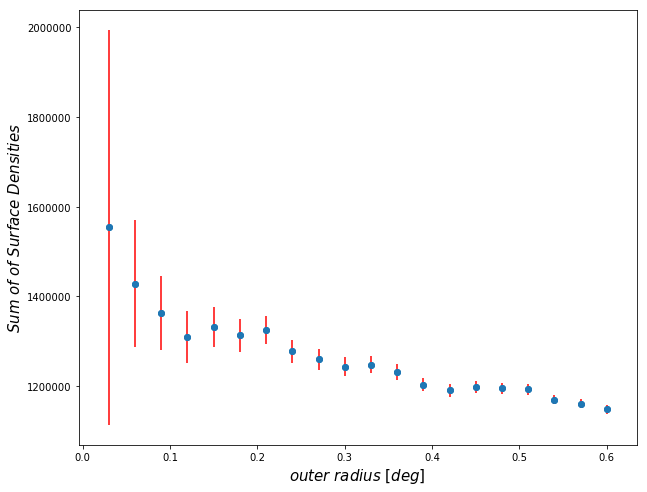

In [42]:
# print(len(sigma))

# sigma_LRG = []
# for i in range(len(sigma)):
#     sigma_LRG.append(np.sum(sigma[i]))
    
# print(sigma_LRG[0])
    
# sigma_cut = sigma_LRG[np.where(z_LRG >= 0.1) & (z_LRG < 0.2)]
# outer_cut = outer_radius[np.where(z_LRG >= 0.1) & (z_LRG < 0.2)]
# error_cut = error[np.where(z_LRG >= 0.1) & (z_LRG < 0.2)]

# print(z_LRG[1])

plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius0, sumSigma0)
plt.errorbar(outer_radius0, sumSigma0, yerr = error0, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

# print(sum_sigma_kpc10)
# print(np.sum(sd))

# surfdens = sd * 6.169**2. # kpc_DA for z ~ 0.5 (median redshift)
# print(np.sum(surfdens))

# print(len(error))
# print(error)

# bkg_cut = []
# for i in range(len(bkg)):
#     bkg_cut.append(np.sum(bkg[i]))
    
# print(len(bkg_cut))
# print(bkg_cut)

# plt.rcParams["figure.figsize"] = [10, 8]
# plt.scatter(outer_radius, bkg_cut)
# # plt.errorbar(outer_cut, sigma_cut, yerr = error_cut, fmt='o', ecolor='red')
# plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
# plt.ylabel(r'$satellites$', fontsize=15)
# plt.show()


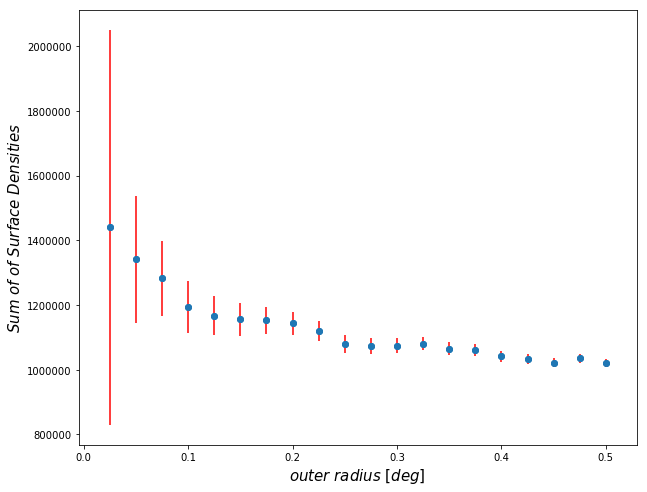

In [29]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius1, sumSigma1)
plt.errorbar(outer_radius1, sumSigma1, yerr = error1, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

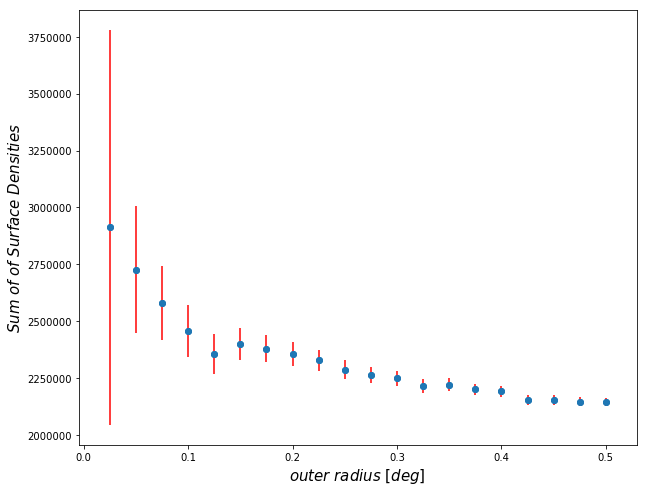

In [30]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius2, sumSigma2)
plt.errorbar(outer_radius2, sumSigma2, yerr = error2, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

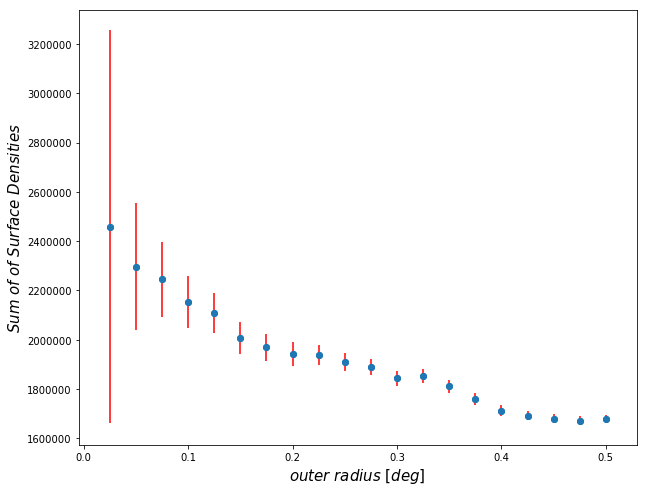

In [31]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius3, sumSigma3)
plt.errorbar(outer_radius3, sumSigma3, yerr = error3, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

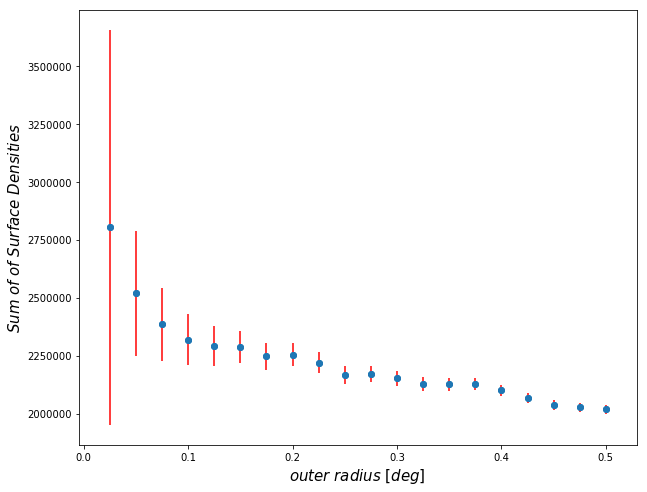

In [32]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius4, sumSigma4)
plt.errorbar(outer_radius4, sumSigma4, yerr = error4, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

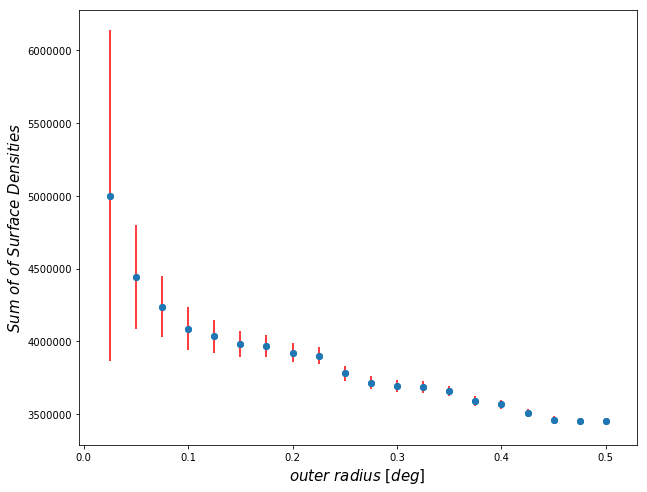

In [33]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius5, sumSigma5)
plt.errorbar(outer_radius5, sumSigma5, yerr = error5, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

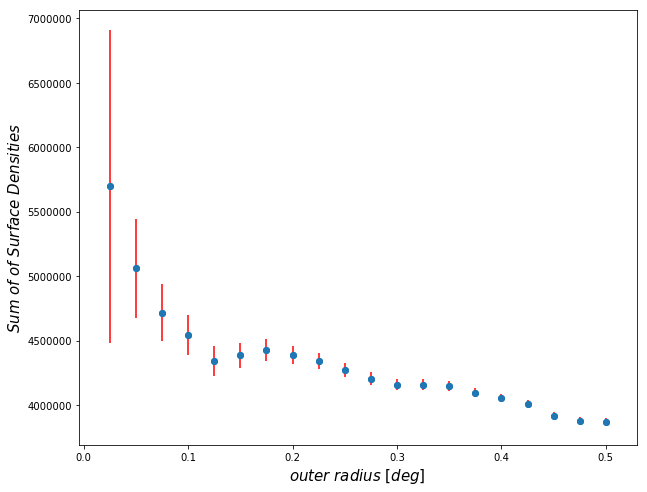

In [34]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius6, sumSigma6)
plt.errorbar(outer_radius6, sumSigma6, yerr = error6, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

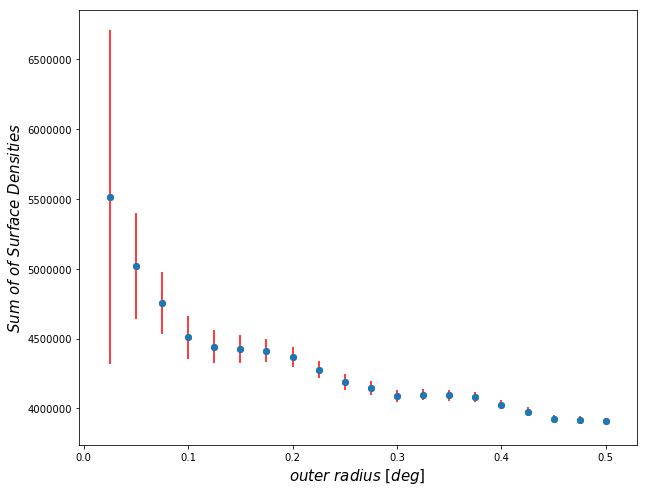

In [35]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius7, sumSigma7)
plt.errorbar(outer_radius7, sumSigma7, yerr = error7, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

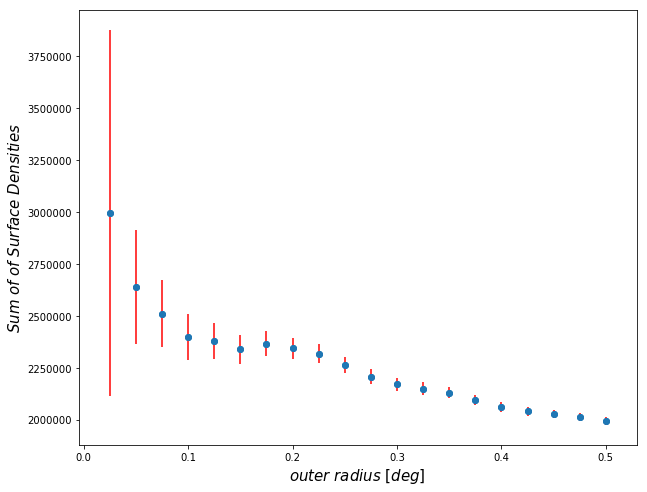

In [36]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius8, sumSigma8)
plt.errorbar(outer_radius8, sumSigma8, yerr = error8, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

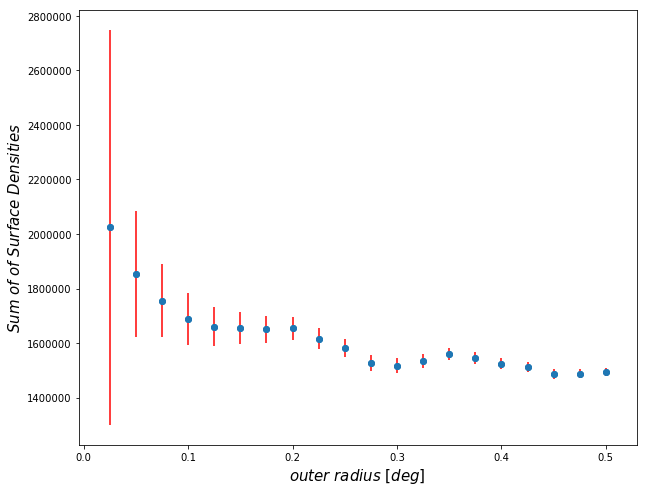

In [37]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius9, sumSigma9)
plt.errorbar(outer_radius9, sumSigma9, yerr = error9, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

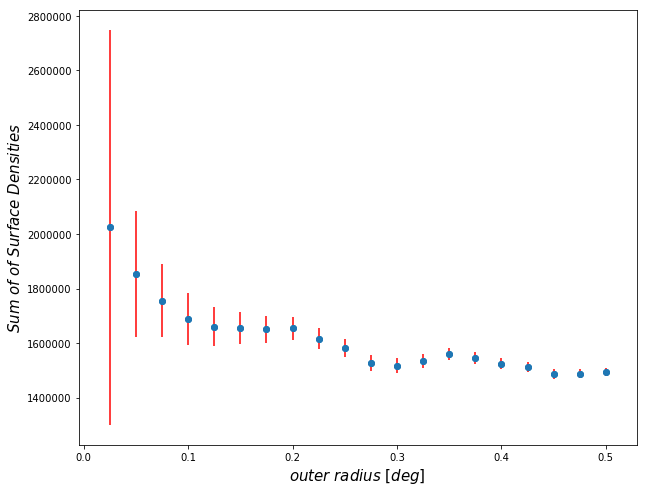

In [38]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(outer_radius9, sumSigma9)
plt.errorbar(outer_radius9, sumSigma9, yerr = error9, fmt='o', ecolor='red')
plt.xlabel(r'$outer$ $radius$ $[deg]$', fontsize=15)
plt.ylabel(r'$Sum$ $of$ $of$ $Surface$ $Densities$', fontsize=15)
plt.show()

In [7]:
Nsat = np.array(near) - np.array(Nbkg)
print("end Nsat")

end Nsat


In [8]:
sumsat, sumsat1z, sumsat2z, sumsat3z, sumsat4z, sumsat5z, sumsat6z, sumsat7z, sumsat1r, sumsat2r, sumsat3r, sumsat4r, sumsat5r, sumsat6r, sumsat7r, sumsat1g, sumsat2g, sumsat3g, sumsat4g, sumsat5g, sumsat6g, sumsat7g, sumsat8g, sumsat1_zmag, sumsat2_zmag, sumsat3_zmag, sumsat4_zmag, sumsat5_zmag, sumsat6_zmag, sumsat7_zmag  = sumNsat(Nsat, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

sumnear, sumnear1z, sumnear2z, sumnear3z, sumnear4z, sumnear5z, sumnear6z, sumnear7z, sumnear1r, sumnear2r, sumnear3r, sumnear4r, sumnear5r, sumnear6r, sumnear7r, sumnear1g, sumnear2g, sumnear3g, sumnear4g, sumnear5g, sumnear6g, sumnear7g, sumnear8g, sumnear1_zmag, sumnear2_zmag, sumnear3_zmag, sumnear4_zmag, sumnear5_zmag, sumnear6_zmag, sumnear7_zmag = sumNN(near, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

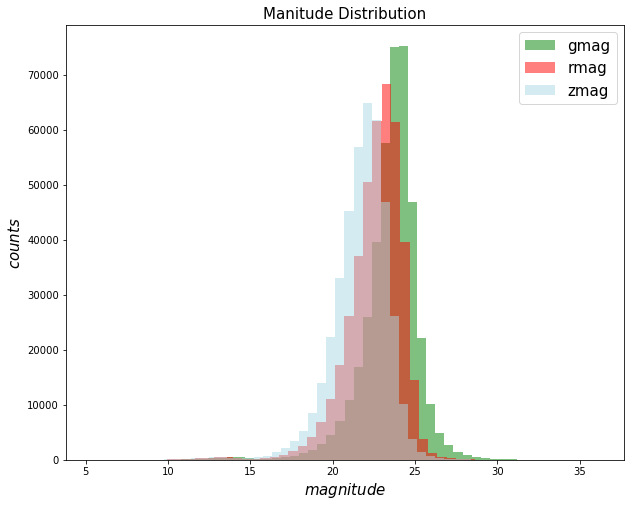

In [15]:
magHist(gmag_BKG, rmag_BKG, zmag_BKG)
plt.show()

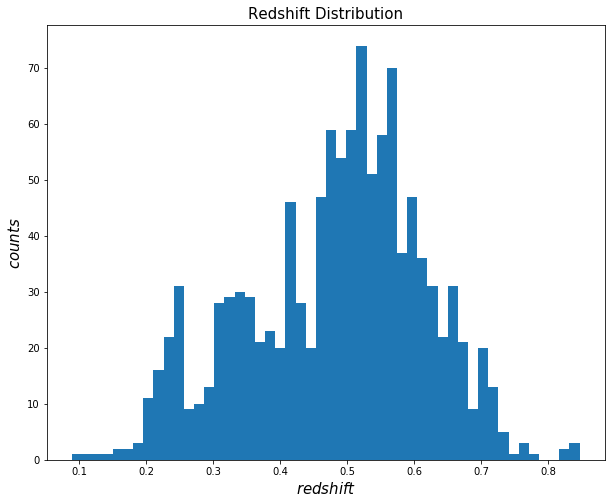

In [16]:
zHist(z_LRG)
plt.show()

mean number of satellites is 16.393863307269044
median number of satellites is 14.27
standard deviation of satellites is 26.05054032751309
standard error is 0.7681885249561131


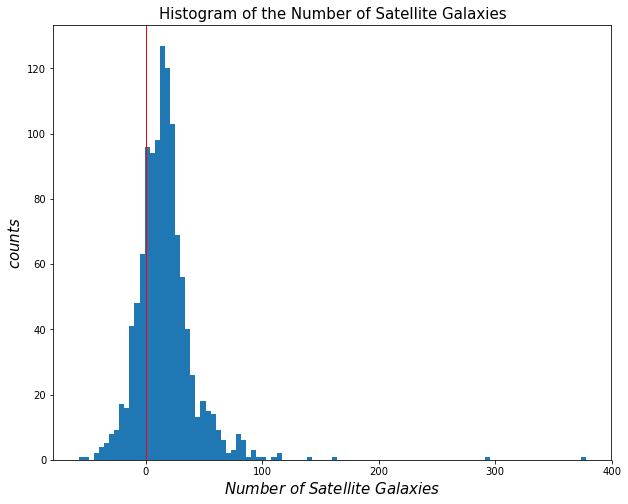

In [33]:
from lrg_plot_functions import *
totalNsat(Nsat)
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/NsatHist.pdf")
# plt.savefig("/Users/mindy/Research/Plots/LRG_Project_Plots/NsatHist.pdf")
plt.show()

mean number of interlopers is 41.82507674485954
median number of interlopers is 35.17333333333334
standard deviation of interloper is 26.290921583497664
standard error is 0.7752769814771803


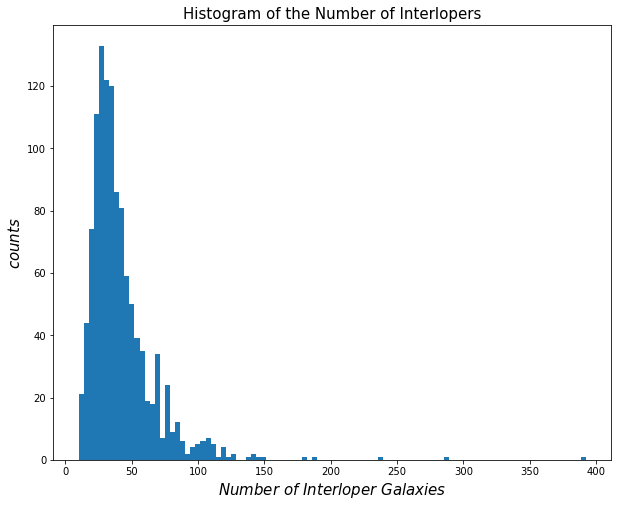

In [9]:
totalNbkg(Nbkg)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/bkgHist.pdf")

plt.show()

mean number of near neighbors is 58.21894005212858
median number of near neighbors is 50.0
standard deviation of near neighbor is 42.82393619172537
standard error is 1.262808984472097


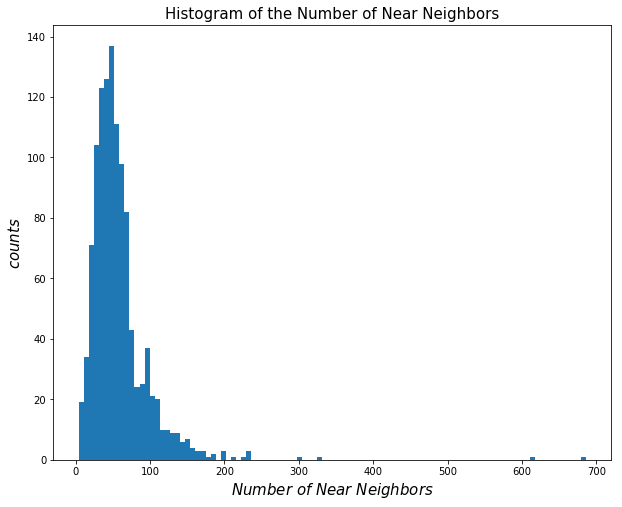

In [11]:
totalNear(near)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/nearHist.pdf")

plt.show()

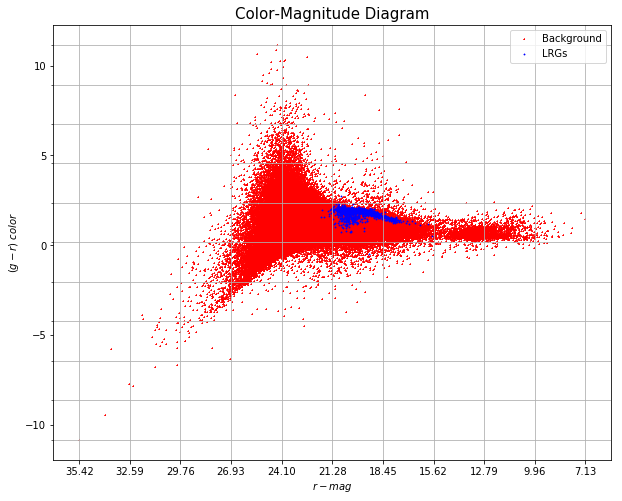

In [20]:
cmd(rmag_BKG, color_BKG, rmag_LRG, color_LRG, xedges, yedges)
plt.show()

The median of Nsat: 14.27
The median of bootmed: 14.27
Low 68% confidence interval: 13.770000000000012
High 68% confidence interval: 14.693333333333339


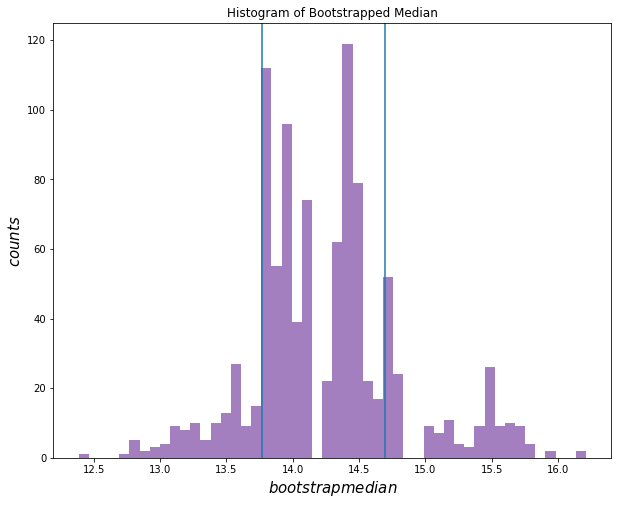

In [12]:
boot_med_plot(1000, 0.68, np.median, sumsat)
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/boothist.pdf")
plt.show()

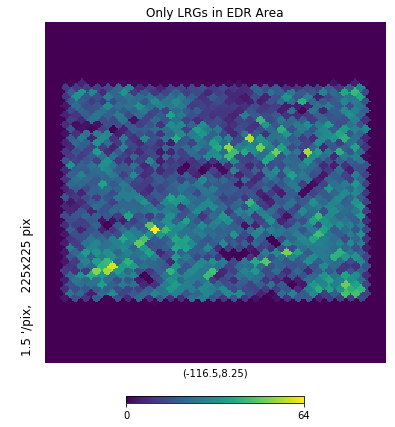

In [9]:
from lrg_plot_functions import *
healpix(ra_BKG, dec_BKG, ra_LRG, dec_LRG, gmag_BKG, rmag_BKG, zmag_BKG)
# plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/healpix1.pdf")
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/healpix2.pdf")
plt.show()

mean number of satellites at z < 0.2: 93.27791666666667
mean number of satellites at 0.2 <= z < 0.3: 30.168773584905658
mean number of satellites at 0.3 <= z < 0.4: 20.667899807321774
mean number of satellites at 0.4 <= z < 0.5: 14.227852684144821
mean number of satellites at 0.5 <= z < 0.6: 12.231111111111112
mean number of satellites at 0.6 <= z < 0.7: 11.110119760479044
mean number of satellites at z < 0.7: 7.0530081300813015
total number of Nsat arrays: 1151


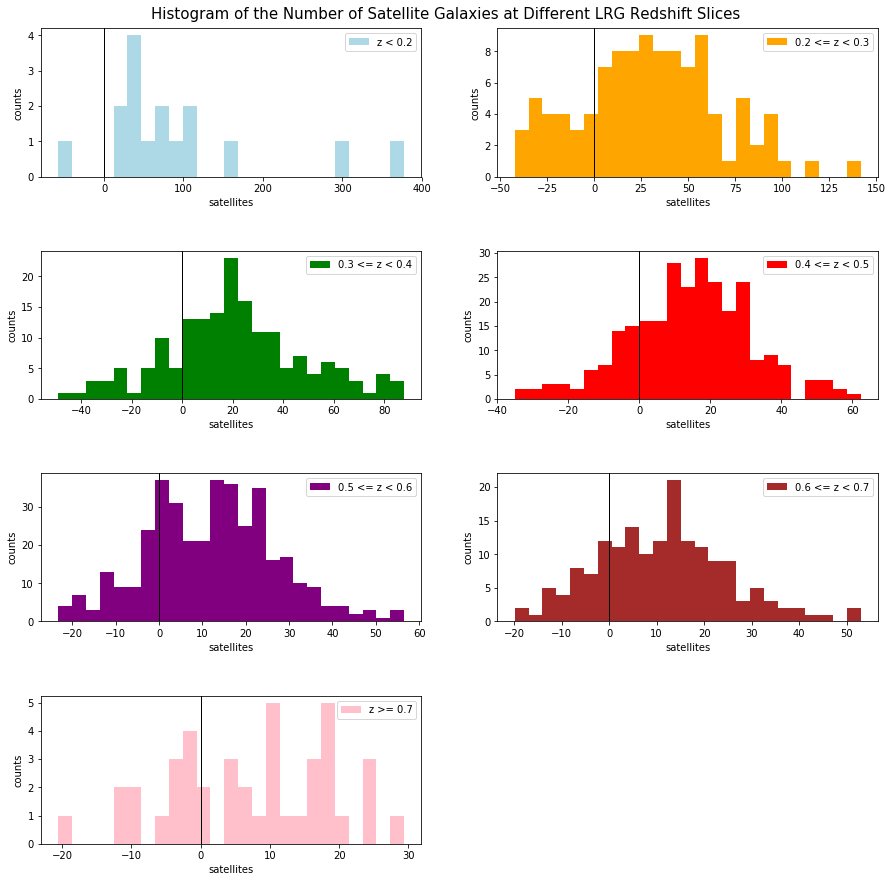

In [13]:
z_cut_Nsat(z_LRG, Nsat)

plt.savefig("/Users/mindy/Research/Plots/LRG_Project_Plots/Nsat_z_hist.pdf")

plt.show()